# Perzeptron Lernalgorithmus (Demo)

# 1 - Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import sklearn.datasets
import h5py
import scipy
from scipy import ndimage
from scipy.special import expit
from PIL import Image
import seaborn as sns

import pandas as pd
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline


# 2- Funktionen


In [2]:
# Perzeptron Vorhersage
def h(w, x):
    return np.sign(np.dot(w, x))

In [3]:
def plot_decision_boundary(ax, w, X, y, title=""):
    """Plot points, shaded regions, and decision boundary"""

    # Create mesh grid for shading
    x_min, x_max = X[:,0].min() - 0.1, X[:,0].max() + 0.1
    y_min, y_max = X[:,1].min() - 0.1, X[:,1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    # Compute decision boundary z = w0 + w1*x + w2*y
    Z = w[0] + w[1] * xx + w[2] * yy

    # Shade regions
    ax.contourf(xx, yy, Z > 0, alpha=0.2, levels=1, colors=["red", "green"])

    # Plot the decision boundary line
    # For w0 + w1*x + w2*y = 0 → y = -(w0 + w1*x)/w2
    x_vals = np.linspace(x_min, x_max, 300)
    if abs(w[2]) > 1e-6:
        y_vals = -(w[0] + w[1] * x_vals) / w[2]
        ax.plot(x_vals, y_vals, "b-", linewidth=2)

    # Plot dataset
    ax.scatter(X[y==1][:,0], X[y==1][:,1], color="green", edgecolors="k")
    ax.scatter(X[y==-1][:,0], X[y==-1][:,1], color="red", edgecolors="k")

    ax.set_title(title)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

In [4]:
# Calculate y for (x,y) on the decision boundary
# w0 + w1*x + w2*y = 0   →   y = -(w0 + w1*x)/w2
def f(w, x):
  return -(w[0] + w[1] * x) / w[2]

In [5]:
# Plot dataset and decision boundary
''' def plot_boundary(X, y, p1=(4, 7), p2=(2, 4.5)):
  plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', label='-1')
  plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='green', label=' 1')

  x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
  y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1

  plt.plot(p1, p2, '-b', label='Decision Boundary')

  plt.legend()
  plt.show() '''

" def plot_boundary(X, y, p1=(4, 7), p2=(2, 4.5)):\n  plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', label='-1')\n  plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='green', label=' 1')\n\n  x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1\n  y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1\n\n  plt.plot(p1, p2, '-b', label='Decision Boundary')\n\n  plt.legend()\n  plt.show() "

# 3 - Datensatz

In [6]:
# Load the Iris dataset
iris = load_iris()

# Select first two classes
X = iris.data[iris.target < 2]  # Features
y = iris.target[iris.target < 2] # Target labels

# select first two features
X = X[:, [0, 1]]

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (100, 2)
Shape of y: (100,)


In [7]:
# Change labels 0 to -1 in y
y = np.where(y == 0, -1, y)
print(np.unique(y))

[-1  1]


In [8]:
print("Zwei Merkmale:")
print(iris.feature_names[0])
print(iris.feature_names[1] + "\n")

print("Zwei Klassen:")
print("-1 : " + iris.target_names[0])
print(" 1 : " + iris.target_names[1])

Zwei Merkmale:
sepal length (cm)
sepal width (cm)

Zwei Klassen:
-1 : setosa
 1 : versicolor


In [9]:
# Create a pandas DataFrame
df = pd.DataFrame(X, columns=["x_1", "x_2"])
df['target'] = y

In [10]:
display(df.head(5))
print("\n...")
display(df.tail(5))

,x_1,x_2,target
0,5.1,3.5,-1
1,4.9,3.0,-1
2,4.7,3.2,-1
3,4.6,3.1,-1
4,5.0,3.6,-1



...


,x_1,x_2,target
95,5.7,3.0,1
96,5.7,2.9,1
97,6.2,2.9,1
98,5.1,2.5,1
99,5.7,2.8,1


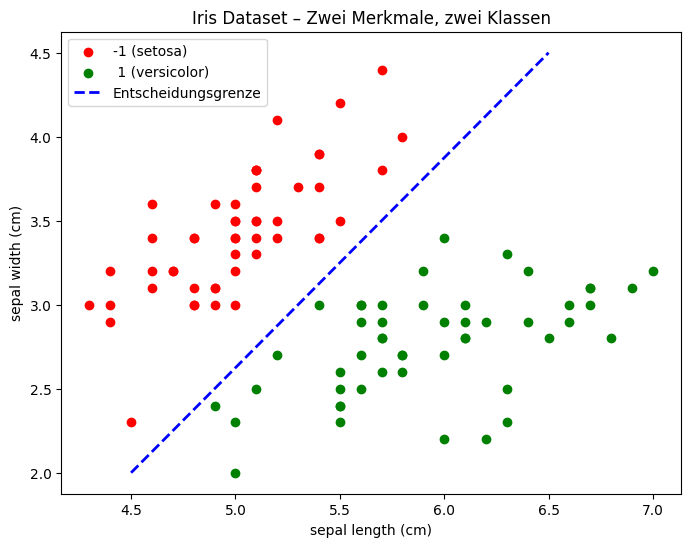

In [11]:
plt.figure(figsize=(8, 6))

plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', label='-1 (setosa)')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='green', label=' 1 (versicolor)')

# Eine gute Entscheidungsgrenze (Decision Boundary):
# Linie zwischen den Punkten (4.5, 2) und (6.5, 4.5).
plt.plot([4.5, 6.5], [2, 4.5], color='blue', linestyle='--', linewidth=2, label='Entscheidungsgrenze')

plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title("Iris Dataset – Zwei Merkmale, zwei Klassen")
plt.legend()
#plt.grid(True)
plt.show()

# 4 - Perzeptron Lernalgorithmus

In [12]:
# ----------------------------------------------------
# Bias-Term hinzufügen: X → [1, x1, x2]
# ----------------------------------------------------
Xb = np.hstack([np.ones((X.shape[0], 1)), X])
print(X.shape)
print(Xb.shape)

(100, 2)
(100, 3)


In [13]:
# Lernrate / Schrittweite
lr = 0.001

In [14]:
# ----------------------------------------------------
# Gewichtsparameter zufällig initialisieren
# ----------------------------------------------------
#np.random.seed(42)
#w = np.random.rand(3)

# Für die Demo starten wir mit "netten" Werten
w = np.array([-3.5, 1.5, -1.3])
w_init = w
w_new = w

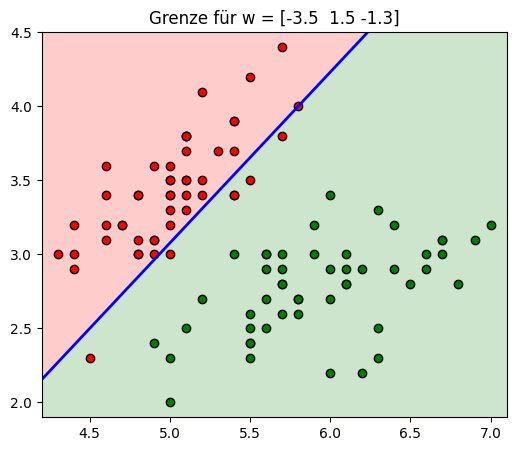

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot_decision_boundary(ax, w, X, y, title=f"Grenze für w = {w}")

In [16]:
# ----------------------------------------------------
# 1. Falsch klassifizierte Punkte
# ----------------------------------------------------
misclassified = []
for i in range(len(Xb)):
    if h(w, Xb[i]) != y[i]:         # Vorhersage != Zielwert
        misclassified.append(i)

print(len(misclassified))

6


In [17]:
# ------------------------------------------------------
# 2. Gewichtsaktualisierung - Perzeptron Lernalgorithmus
# w_new = w + lr * y * x
# ------------------------------------------------------
if len(misclassified) > 0:
    idx = np.random.choice(misclassified)
    x_mis = Xb[idx]
    y_mis = y[idx]

    print(f"Zufällig ausgewählter falsch klassifizierter Punkt: {x_mis}")
    print(f"Zielwert des ausgewählten Punktes: {y_mis}")
    w_new = w + lr * y_mis * x_mis

else:
    # Alles richtig klassifiziert
    w_new = w

Zufällig ausgewählter falsch klassifizierter Punkt: [1.  5.7 3.8]
Zielwert des ausgewählten Punktes: -1


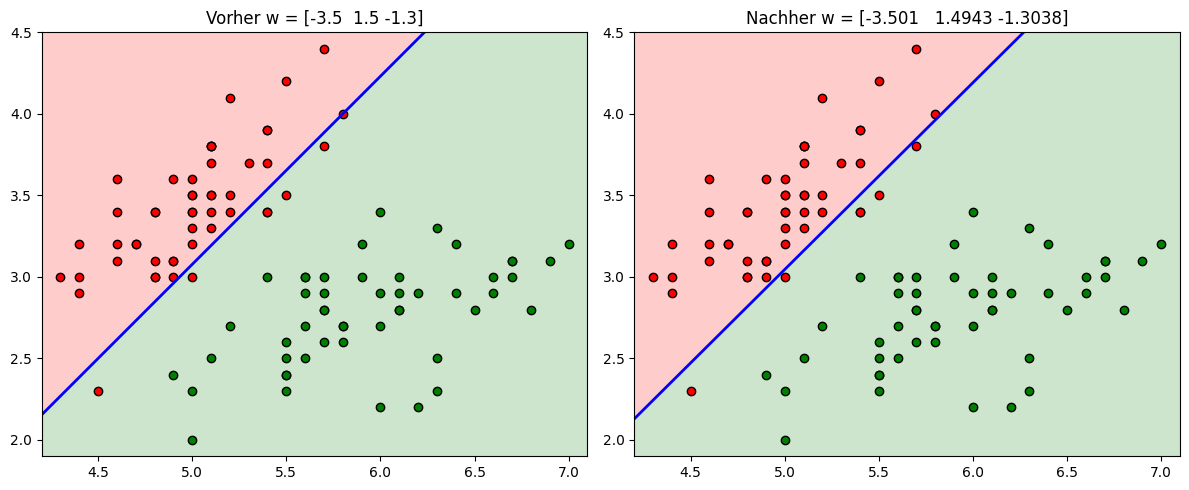

In [18]:
# ----------------------------------------------------
# PLOT vorher-nachher
# ----------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
t = f"Grenze für w = {w}"
plot_decision_boundary(ax[0], w,     X, y, title=f"Vorher w = {w}")
plot_decision_boundary(ax[1], w_new, X, y, title=f"Nachher w = {w_new}")

plt.tight_layout()
plt.show()

4
Zufällig ausgewählter falsch klassifizierter Punkt: [1.  5.4 3.4]
Zielwert des ausgewählten Punktes: -1


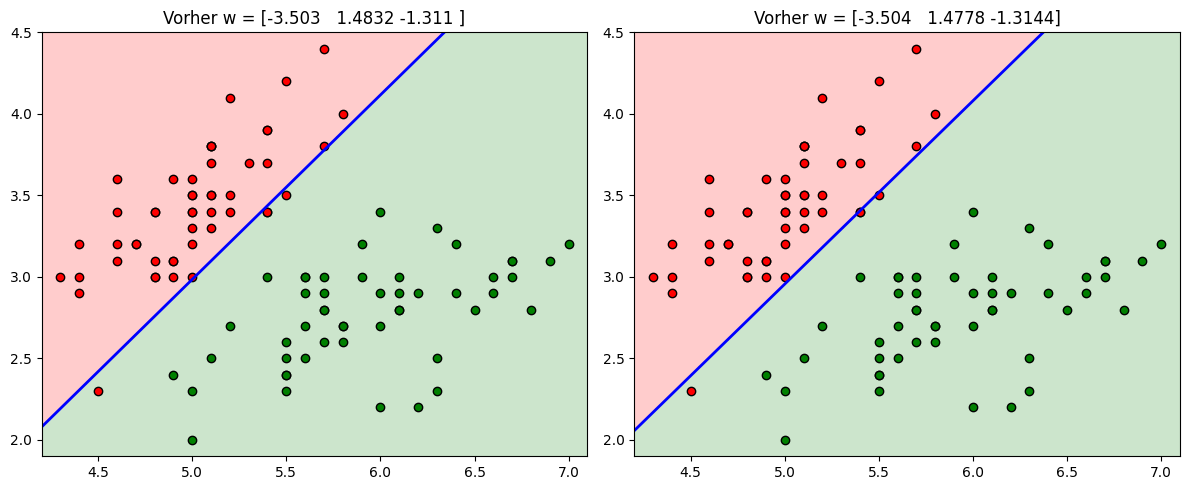

In [21]:
# Loop: Diese Zelle wiederholt ausführen und generierten Plot beobachten

w = w_new

# ----------------------------------------------------
# 1. Falsch klassifizierte Punkte
# ----------------------------------------------------
misclassified = []
for i in range(len(Xb)):
    if h(w, Xb[i]) != y[i]:
        misclassified.append(i)

print(len(misclassified))

# ------------------------------------------------------
# 2. Gewichtsaktualisierung - Perzeptron Lernalgorithmus
# ------------------------------------------------------
if len(misclassified) > 0:
    idx = np.random.choice(misclassified)
    x_mis = Xb[idx]
    y_mis = y[idx]


    print(f"Zufällig ausgewählter falsch klassifizierter Punkt: {x_mis}")
    print(f"Zielwert des ausgewählten Punktes: {y_mis}")

    w_new = w + lr * y_mis * x_mis

else:
    # Alles richtig klassifiziert
    w_new = w

# ----------------------------------------------------
# PLOT vorher-nachher
# ----------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundary(ax[0], w,     X, y, title=f"Vorher w = {w}")
plot_decision_boundary(ax[1], w_new, X, y, title=f"Vorher w = {w_new}")

plt.tight_layout()
plt.show()

# 5 - Animation

In [22]:
def perceptron_updates(Xb, y, w_init, max_steps=100, lr=0.001):
    w = w_init
    yield w
    for step in range(max_steps):
      misclassified = []
      for i in range(len(Xb)):
          if np.sign(Xb[i] @ w) != y[i]:
              misclassified.append(i)

      if len(misclassified) > 0:
          idx = np.random.choice(misclassified)

          #print(f"Zufällig ausgewählter falsch klassifizierter Punkt: {Xb[idx]}")
          #print(f"Zielwert des ausgewählten Punktes: {y[idx]}")
          w = w + lr * y[idx] * Xb[idx]
          yield w
      else:
          yield w

Zufällig ausgewählter falsch klassifizierter Punkt: [1.  5.5 3.5]
Zielwert des ausgewählten Punktes: -1
Zufällig ausgewählter falsch klassifizierter Punkt: [1.  5.5 3.5]
Zielwert des ausgewählten Punktes: -1
Zufällig ausgewählter falsch klassifizierter Punkt: [1.  5.7 3.8]
Zielwert des ausgewählten Punktes: -1
Zufällig ausgewählter falsch klassifizierter Punkt: [1.  4.5 2.3]
Zielwert des ausgewählten Punktes: -1
Zufällig ausgewählter falsch klassifizierter Punkt: [1.  5.4 3.4]
Zielwert des ausgewählten Punktes: -1
Zufällig ausgewählter falsch klassifizierter Punkt: [1.  4.5 2.3]
Zielwert des ausgewählten Punktes: -1
Zufällig ausgewählter falsch klassifizierter Punkt: [1.  4.5 2.3]
Zielwert des ausgewählten Punktes: -1
Zufällig ausgewählter falsch klassifizierter Punkt: [1.  4.5 2.3]
Zielwert des ausgewählten Punktes: -1
Zufällig ausgewählter falsch klassifizierter Punkt: [1.  4.5 2.3]
Zielwert des ausgewählten Punktes: -1


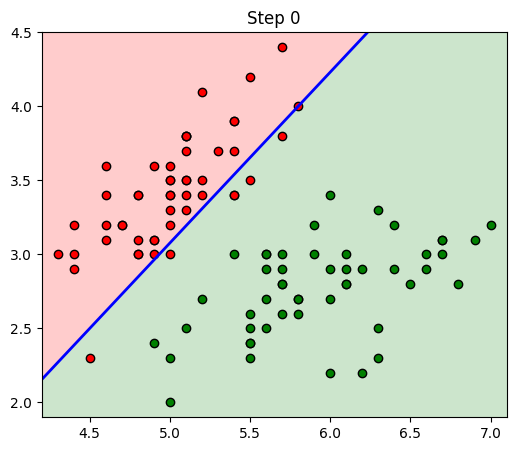

In [26]:
# ----------------------------------------------------
# Matplotlib animation
# ----------------------------------------------------

from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots(figsize=(6, 5))

updates = list(perceptron_updates(Xb, y, w_init, max_steps=20, lr=0.001))

def animate(frame):
    ax.clear() # Clear the previous frame's content
    w = updates[frame]
    plot_decision_boundary(ax, w, X, y)
    ax.set_title(f"Step {frame}")

ani = FuncAnimation(
    fig, animate, frames=len(updates),
    interval=300, repeat=False
)
ani.save("perceptron.gif", writer="imagemagick", fps=1)
#plt.show()

In [ ]:
import base64
from IPython.display import HTML

gif_data = base64.b64encode(open("perceptron.gif", "rb").read()).decode()
HTML(f'<img src="data:image/gif;base64,{gif_data}">')